# 1. Preparing our data

## 1.1 Description of the raw data

Our raw data is given in the form of three vectors:

* x: energy
* y: number of photons
* y_err: error in y, which should be in our case equal to $\sqrt{y}$

These vectors are placed in the file corresponding to that spectrum, for example

|    X     |   Y      | Y err    |
|----------|----------|----------|
| 6025.88  | 588.0    | 24.25    |
| 6063.11  | 637.0    | 25.24    |
| 6100.57  | 651.0    | 25.51    |
| 6138.25  | 580.0    | 24.08    |
| 6176.17  | 676.0    | 26.0     |
| 6214.33  | 768.0    | 27.71    |

## 1.2 Lower the number of channels

Our spectra are given in the energy range $\left[100,300k\right]$ eV. But we are interested mostly on ~ $\left[1,50\right]$ keV. In addition, we want to reduce the number of channels (energy-bins) because it will have a negative impact on the performance of the DL model. There are different ways to achieve this, and we can change this later, therefore now we will simply average neighbor energy bins. This will also help us to smooth a little bit the spectra. 


x is in [1189.173533478819,46705.88382514706]
Number of channels: 150


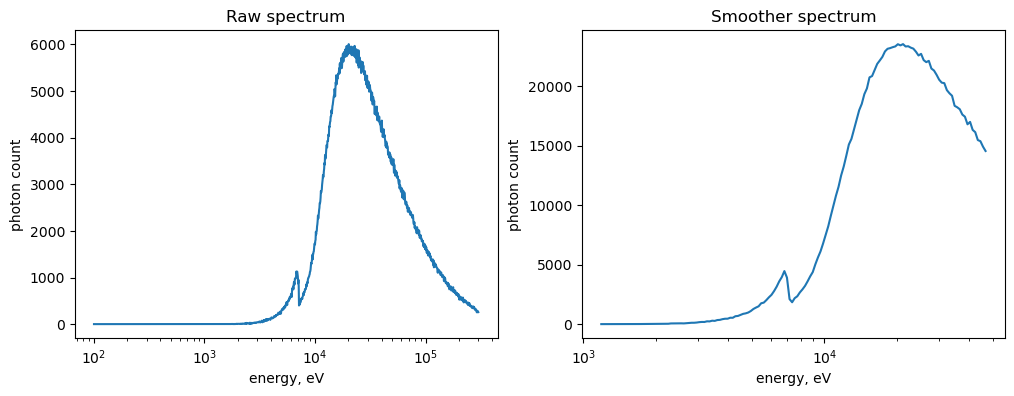

In [1]:
from one_time_utilities import *

x, y, _ = x_y_z(path=".dummydata/224_-1_1xfe_6070_51_8.9e+20_1.1e+26_33_CONTINUUM_NONE.spectrum")
x_smooth,y_smooth = reduce_energy_bins_number(x,y,times_=2)

plot_pair_spectra(x,y,x_smooth,y_smooth,title_left="Raw spectrum",title_right="Smoother spectrum")

## 1.3 Normalization

In order to pass our data into the DL model we will normalize the spectra with the given formula (see: https://arxiv.org/abs/2206.04602):

$$
y = \frac{y_{count} - \overline{y_{count}}}{\sigma (y_{count})}
$$

Therefore we will pass that normalized $y$ to our DL model.

x is in [1189.173533478819,46705.88382514706]
Number of channels: 150
Mean value: 0.00,    Stdev: 1.00


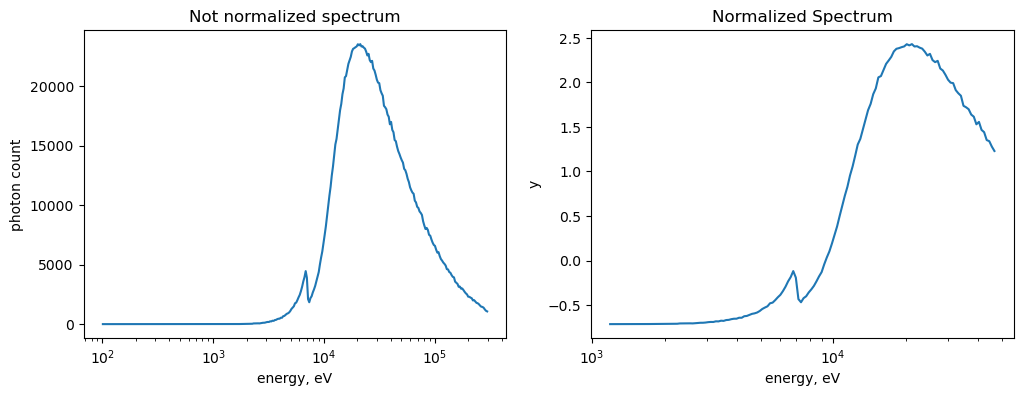

In [2]:
x_normalized, y_normalized = normalize_spectrum(x_smooth,y_smooth)

plot_pair_spectra(x_smooth,y_smooth,
                  x_normalized,y_normalized,
                  title_left="Not normalized spectrum", 
                  title_right="Normalized Spectrum", 
                  y_label_right="y")

print(f"Mean value: {np.mean(y_normalized):.2f},    Stdev: {np.std(y_normalized):0.2f}")

## 1.4 TODO: EXTRACT LABEL DATA FROM THE SPECTRUM

We need now to extract the label data from the spectrum file.